<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import torch

### 0. Fix data type and device for this notebook

In [3]:
# check for CUDA availability (NVIDIA GPU)
if torch.cuda.is_available():
    # get the CUDA device name
    device = torch.device('cuda')          # CUDA-device object
else:
    device = torch.device('cpu')           # cpu-device object

print(device)

cpu


In [4]:
# fix the data type
dtype = torch.float32
print(dtype)

torch.float32


### 1. Нахождение сложной производной

Найдите производную по x от функции 
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [5]:
def find_x_derivative(x, y):

    # different ways to set:
    #   the data type: Floattensor (dtype = torch.float32)
    #   gradient to be calculated (we want derivatives): requires_grad=True
    x = torch.tensor([x], dtype=dtype, requires_grad=True)
    y = torch.FloatTensor([y]).requires_grad_(True)

    # check - they give the same results
    print('x.dtype:', x.dtype, '| x.requires_grad:', x.requires_grad)
    print('y.dtype:', y.dtype, '| y.requires_grad:', y.requires_grad)

    #### evaluating the expression
    #
    left_left_brack = torch.tan(x) * x * x / y
    right_left_brack = torch.log(torch.exp(- x.pow(2)  + 3) + x.pow(3) *y)
    
    left = torch.sin(left_left_brack + right_left_brack)
    right = torch.tan(x.pow(2) * torch.exp(x.pow(9)))

    out = left * right
    #
    ####

    # calculating the gradients
    out.backward()

    # return the derivative wrt x
    return x.grad


np.round(find_x_derivative(1, 21).numpy(), 3)

x.dtype: torch.float32 | x.requires_grad: True
y.dtype: torch.float32 | y.requires_grad: True


array([-9.021], dtype=float32)

If you have a one element tensor, use ``.item()`` to get the value as a
Python number



In [8]:
# checking that torch.log works fine
torch.log(torch.tensor(2.718281828459045, dtype=dtype)).item()

1.0

In [9]:
# checking that torch.exp works fine
torch.exp(torch.tensor(1, dtype=dtype)).item()

2.7182817459106445

# 2. Нахождение косинусной близости

Вам даны две матрицы A и B. Необходимо посчитать косинусную близость между строчками матрицы A и столбцами матрицы B. Ответ - матрица чисел, где номер строки - номер строки из матрицы А, а номер столбца - номер столбца из В, от которых бралась косинусная близость.

Напомним, что косинусная близость двух векторов - косинус угла между ними. В n-мерном пространстве косинус угла между веткорами удобнее всего через скалярное произведение:
$$\cos(angle(x, y)) = \frac{x \cdot y}{\left\|x\right\| \left\|y\right\|}$$

(Наша операция очень похожа на умножение матриц)

In [42]:
A = [[1, -47, 25, -3],
     [10, 17, -15, 22],
     [-3, -7, 26, 36],
     [12, -27, -42, 0]]

B = [[-50, -13, 1, 10, 1242],
     [21, 48, -13, -14, -20],
     [20, 15, 11, 43, 11],
     [11, 103, 147, 27, -8]]  
A = torch.tensor(A, dtype=dtype)
B = torch.tensor(B, dtype=dtype)

print(A)
print(B)

tensor([[  1., -47.,  25.,  -3.],
        [ 10.,  17., -15.,  22.],
        [ -3.,  -7.,  26.,  36.],
        [ 12., -27., -42.,   0.]])
tensor([[-5.0000e+01, -1.3000e+01,  1.0000e+00,  1.0000e+01,  1.2420e+03],
        [ 2.1000e+01,  4.8000e+01, -1.3000e+01, -1.4000e+01, -2.0000e+01],
        [ 2.0000e+01,  1.5000e+01,  1.1000e+01,  4.3000e+01,  1.1000e+01],
        [ 1.1000e+01,  1.0300e+02,  1.4700e+02,  2.7000e+01, -8.0000e+00]])


In [43]:
# dim=1 calculates norm for every row
torch.norm(A, dim=1)

tensor([53.3292, 33.1361, 45.0555, 51.3517])

In [44]:
# keepdim=True makes sure that the result is not flattened
torch.norm(A, dim=1, keepdim=True)

tensor([[53.3292],
        [33.1361],
        [45.0555],
        [51.3517]])

In [45]:
def get_cos_sim(A, B):
    """
        A, B - torch float tensors
    """
    # YOUR CODE HERE
    
    return torch.matmul(
        A / torch.norm(A, dim=1, keepdim=True),
        B / torch.norm(B, dim=0, keepdim=True))
    

np.round(torch.mean(get_cos_sim(A, B)).numpy(), 3)

0.15

# 3. Линейная регрессия

Раньше мы самостоятельно считали производные, чтобы находить веса линейной регрессии с помощью градиентного спуска. Теперь нам нужно использовать для этого PyTorch и его autograd. 

**Важно**: на самом деле .backward не обновляет содержимое матриц с производными (some_tensor.grad), а прибавляет к ним только что посчитаные значения проивзодных. Это значит, что вызвав .backward дважды, вы получите удвоенную производную. Так как мы обновляем веса в цикле и много раз вызываем .backward, то очень быстро мы получим мусор в some_tensor.grad, если не будем его каждый раз обнулять. Таким образом, в конц итериации после использования производных обнулите значения в матрице производных для всех нужных Вам переменных. Делается это вот так 
> some\_tensor.grad.data.zero_()

In [46]:
class LinearRegression:

    def get_loss(self, preds, y):
        """
        @param preds: model predictions
        @param y: true values (labels)

        @return mse: evaluated MSE given the input
        """
        return torch.mean((preds - y).pow(2))
    

    def init_weights(self, input_size, output_size):
        """
        Initialize model parameters
        W - matrix of size (input_size, output_size)
        with random initialization from 
        uniform distribution (torch.rand())
        b - vector of isze (1, output_size)
        initialized with zeros
        """
        torch.manual_seed(0) #need for reproducability of the results
        self.W = torch.rand(input_size, output_size,  requires_grad=True)
        self.b = torch.zeros(1, output_size, requires_grad=True)


    def fit(self, X, y, X_val=None, y_val=None, num_epochs=1000, lr=0.001):
        """
        Training of the linear regression model via gradient descent
        @param X: dementions (num_samples, input_shape)
        @param y: dementions (num_samples, output_shape)
        @param num_epochs: number of gradient descent iterations through the whole data set
        @param lr: learning rate (gradient descent step)
        @return metrics: vector containing MSE values on every step of thte gralient descent
        """
        self.init_weights(X.shape[1], y.shape[1])
        metrics = []
        if (X_val is not None) and (y_val is not None):
            val_metrics = []
        else:
            val_metrics = None


        for _ in range(num_epochs):

            # make predictions
            preds = self.predict(X)

            # evaluate the loss
            loss = self.get_loss(preds, y)

            # propagate the error and calculate the gradients
            loss.backward()

            # use the wrapper not to create too many nodes in the operation tree
            # otherwise the model will run out of memory very quickly
            with torch.no_grad():
                self.W -= lr * self.W.grad
                self.b -= lr * self.b.grad
            
            # reset gradients to 0 to have them ready for next iteration
            self.W.grad.data.zero_()
            self.b.grad.data.zero_()

            metrics.append(self.get_loss(preds, y).data)

            if (X_val is not None) and (y_val is not None):
                val_preds = self.predict(X_val)
                val_metrics.append(self.get_loss(val_preds, y_val).data)

        return metrics, val_metrics

    def predict(self, X):
        """
        Make predictions given design matrix X
        """
        return X @ self.W + self.b

1. Сгенерируйте данные с помощью make_regression с параметрами n_targets=3, n_features=2, noise=10, random_state=42. 
2. Обучите модель линейной регрессии, оставив в fit параметры num_epochs и lr по умолчанию (обратите внимание, что перед обучением нужно привести данные к типу, использующимся в torch) 
2. Посчитайте среднее значение метрики MSE по всем итерациям цикла в fit (массив из значений MSE на каждой итерации возвращается из метода fit). Ответом, который необходимо сдать в систему, будет число, округленное до 3х знаков после запятой.

In [21]:
X, Y = datasets.make_regression(n_targets=3, n_features=2, noise=10, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [47]:
X, Y = datasets.make_regression(n_targets=3, n_features=2, noise=10, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# X and Y do not require gradient to be calculated with rrespect to them
# So we keep the default require_grad=False
X_train = torch.tensor(X_train, dtype=dtype, device=device)
X_test = torch.tensor(X_test, dtype=dtype, device=device)
Y_train = torch.tensor(Y_train, dtype=dtype, device=device)
Y_test = torch.tensor(Y_test, dtype=dtype, device=device)

print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print()

print("X_train.dtype: ", X_train.dtype)
print("Y_train.dtype: ", Y_train.dtype)
print()

print("X_train.device: ", X_train.device)
print("Y_train.device: ", Y_train.device)


X_train.shape:  torch.Size([75, 2])
Y_train.shape:  torch.Size([75, 3])

X_train.dtype:  torch.float32
Y_train.dtype:  torch.float32

X_train.device:  cpu
Y_train.device:  cpu


In [48]:
model = LinearRegression()

In [49]:
mse = model.fit(X=X_train, y=Y_train,
                X_val=X_test, y_val=Y_test)                    

In [50]:
train_mse = mse[0]
test_mse = mse[1]

In [51]:
print(np.mean(train_mse))
print(np.mean(test_mse))

4228.606
4172.521


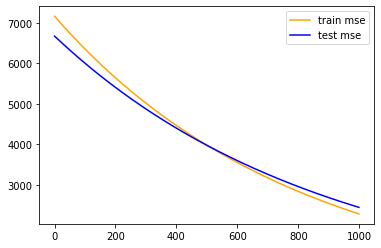

In [52]:
%matplotlib inline

plt.plot(train_mse, label="train mse", color="orange")
plt.plot(test_mse, label="test mse", color="blue")
plt.legend()

## Tests

In [53]:
X, Y = datasets.make_regression(n_targets=3, n_features=2, noise=10, random_state=42)

# X and Y do not require gradient to be calculated with rrespect to them
# So we keep the default require_grad=False
X = torch.tensor(X, dtype=dtype, device=device)
Y = torch.tensor(Y, dtype=dtype, device=device)

print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)
print()

print("X.dtype: ", X.dtype)
print("Y.dtype: ", Y.dtype)
print()

print("X.device: ", X.device)
print("Y.device: ", Y.device)

X.shape:  torch.Size([100, 2])
Y.shape:  torch.Size([100, 3])

X.dtype:  torch.float32
Y.dtype:  torch.float32

X.device:  cpu
Y.device:  cpu


In [54]:
def init_weights(input_size, output_size):
    """
    Инициализирует параметры модели
    W - матрица размерности (input_size, output_size)
    инициализируется рандомными числами из
    uniform распределения (torch.rand())
    b - вектор размерности (1, output_size)
    инициализируется нулями
    """
    torch.manual_seed(0) #необходимо для воспроизводимости результатов
    W = torch.rand(input_size, output_size,  requires_grad=True)
    b = torch.zeros(1, output_size, requires_grad=True)

    return W, b

# initializing weights
W, b = init_weights(X.shape[1], Y.shape[1])

In [55]:
print("W.shape: ", W.shape)
print("b.shape: ", b.shape)
print()

print("W.dtype: ", W.dtype)
print("b.dtype: ", b.dtype)
print()

print("W.device: ", W.device)
print("b.device: ", b.device)
print()

print("W.requires_grad: ", W.requires_grad)
print("b.requires_grad: ", b.requires_grad)
print()

W.shape:  torch.Size([2, 3])
b.shape:  torch.Size([1, 3])

W.dtype:  torch.float32
b.dtype:  torch.float32

W.device:  cpu
b.device:  cpu

W.requires_grad:  True
b.requires_grad:  True



In [56]:
def predict(X):
    """
    Думаю, тут все понятно. Сделайте свои предсказания :)
    """
    return X @ W + b

preds = predict(X)

In [57]:
print("preds.shape: ", preds.shape)

preds.shape:  torch.Size([100, 3])


In [58]:
def get_loss(preds, y):
    """
    @param preds: model predictions
    @param y: true values (labels)

    @return mse: evaluated MSE given the input
    """
    # возьмите средний квадрат ошибки по всем выходным переменным
    # то есть сумму квадратов ошибки надо поделить на количество_элементов * количество_таргетов
    return torch.mean((preds - y).pow(2))


# calculate for test data
loss = get_loss(preds, Y)

In [59]:
loss

tensor(7046.5273, grad_fn=<MeanBackward0>)

In [60]:
loss.backward()

In [61]:
print('W.grad: \n', W.grad, '\n')
print('b.grad: \n', b.grad)

W.grad: 
 tensor([[-48.6620, -25.2062, -20.9846],
        [-43.9858, -36.6930, -34.1339]]) 

b.grad: 
 tensor([[3.9607, 4.4403, 5.5293]])


In [62]:
print('W.data: \n', W.data, '\n')
print('b.data: \n', b.data)

W.data: 
 tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341]]) 

b.data: 
 tensor([[0., 0., 0.]])


In [63]:
 lr=0.001

In [64]:
W.data -= lr * W.grad
b.data -= lr * b.grad

In [65]:
print('W.data: \n', W.data, '\n')
print('b.data: \n', b.data)

W.data: 
 tensor([[0.5449, 0.7934, 0.1095],
        [0.1760, 0.3441, 0.6682]]) 

b.data: 
 tensor([[-0.0040, -0.0044, -0.0055]])
